## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

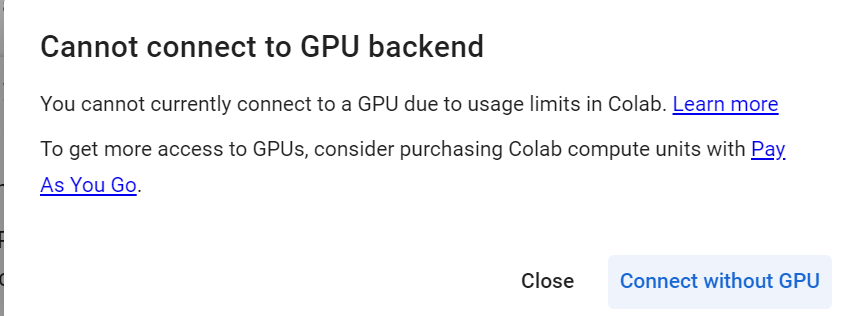

In [ ]:
# check for GPU usage to confirm PyTorch sees the GPU
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

## Installing libraries

In [ ]:
!pip install numpy==1.25.2 --no-cache-dir -q

!pip install -q \
    gensim==4.3.1 \
    sentence-transformers==2.3.1 \
    transformers==4.36.2 \
    huggingface_hub==0.21.3 \
    scikit-learn==1.2.2 \
    pandas==1.5.3 \
    matplotlib==3.7.1 \
    seaborn==0.13.1

!pip install -q \
    numpy==1.25.2 \
    scipy==1.11.4 \
    gensim==4.3.1



## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/stock_news.csv")

## Data Overview

In [ ]:
# checking the first five rows of the data
data.head()

In [ ]:
# checking the shape of the data
data.shape

**Observations**

- Data has 349 rows and 8 columns

In [ ]:
data.info()

**Observations**

- 349 rows and 8 columns. The columns include Date, News, Open, High, Low, Close, Volume, and Label. Key observations:

Data Types:
Date and News are of type object.
Open, High, Low, Close are float64.
Volume and Label are int64.
Non-Null Values:
All columns have 349 non-null values, indicating no missing data.

In [ ]:
# Null Checks

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

**Observations**

- There are no missing values

In [ ]:
# Basic statistics for numeric features
data.describe()

**Observations**

- The data.describe() output shows that all numeric columns have 349 entries with no missing values. Stock prices (Open, High, Low, Close) average around $45 with moderate variability, while trading volumes show significant variability. Sentiment labels (-1, 0, 1) indicate a slight bias toward negative sentiment, and percentiles highlight the distribution of stock prices and volumes.

In [ ]:
# check the data types of the columns
data.dtypes

**Observations**

- This contains columns such as Date, News, Open, High, Low, Close, Volume, and Label. Numeric columns like stock prices and trading volumes are of type float64 or int64, while Date and News are object types.

In [ ]:
# Display unique values in the Label column
print("\nLabel distribution:")
print(data['Label'].value_counts())

**Observations**

- The Label column distribution shows that the majority of news articles are neutral (170), followed by negative (99) and positive (80). This indicates a slight imbalance in sentiment classes, with neutral sentiment being the most common. This imbalance may need to be addressed during model training to ensure fair performance across all sentiment classes.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

## Univariate Analysis

We will now analyze individual features in the dataset to understand their distribution. This includes examining the frequency of sentiment labels, the distribution of stock prices (Open, High, Low, Close), and trading volume. These plots help us understand how skewed or balanced the variables are and identify any unusual patterns.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Countplot for sentiment labels
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=data, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.show()

# Print value counts for clarity
print("Sentiment Label Counts:\n", data['Label'].value_counts())

**Observations**

- The bar chart shows the distribution of sentiment labels in the dataset, with neutral sentiment (0) being the most frequent, followed by negative (-1) and positive (1). This indicates a class imbalance, with neutral sentiment dominating the dataset. Addressing this imbalance may be necessary to ensure fair model performance across all sentiment classes.

In [ ]:
# Plotting distributions of numeric stock market features
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Observations**

- The histograms show the distributions of stock prices (Open, High, Low, Close) and Volume. Stock prices are slightly right-skewed, with most values concentrated between $40 and $50, while Volume exhibits a more pronounced right skew, with most values around 1.0e+08. These distributions suggest that stock prices are relatively stable, but trading volumes vary significantly.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

## Bivariate Analysis

In this section, we will analyze how sentiment labels are related to stock market variables such as Open, High, Low, Close, and Volume. This can help us understand whether certain sentiment types are associated with specific stock price movements or trading volumes. Visualizing these relationships may reveal patterns that can be useful for predictive modeling.


In [ ]:
# Boxplots of stock price features grouped by sentiment label
price_cols = ['Open', 'High', 'Low', 'Close']

plt.figure(figsize=(16, 10))
for i, col in enumerate(price_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x='Label', y=col, hue='Label', palette='Set2', dodge=False)
    plt.title(f'{col} Price by Sentiment Label')
    plt.xlabel('Sentiment')
    plt.ylabel(f'{col} Price')
    plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


**Observations**

- The boxplots show the distribution of stock prices (Open, High, Low, Close) across sentiment labels (-1, 0, 1). Positive sentiment (1) generally corresponds to higher median stock prices compared to neutral (0) and negative (-1) sentiments. However, there is significant overlap in the interquartile ranges, indicating that sentiment alone may not fully explain stock price variations. Outliers are present across all sentiment categories, particularly in the positive sentiment group.

In [ ]:
# Boxplot of trading volume by sentiment label
plt.figure(figsize=(6, 4))
sns.boxplot(x='Label', y='Volume', hue='Label', data=data, palette='coolwarm', dodge=False)
plt.title('Trading Volume by Sentiment Label')
plt.xlabel('Sentiment')
plt.ylabel('Volume')
plt.legend([], [], frameon=False)
plt.show()


**Observations**

- The boxplot shows the distribution of trading volumes across sentiment labels (-1, 0, 1). Neutral sentiment (0) has the widest range of trading volumes, while negative (-1) and positive (1) sentiments have relatively narrower ranges. Outliers are present in all sentiment categories, indicating occasional spikes in trading activity regardless of sentiment.

## **Data Preprocessing**

## Data Preprocessing

Before building models, we need to prepare the dataset. This includes:
- Splitting the data into features and target
- Splitting into training, validation, and test sets
- Resetting index for easier handling
- Ensuring text and label consistency

We’ll also clean and preprocess the text data later as part of embedding preparation for the sentiment analysis models.


In [ ]:
#splitting datasets into training and testing sets.
from sklearn.model_selection import train_test_split
#Imports tools for data preprocessing including label encoding, one-hot encoding, and standard scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
#Imports a class for imputing missing values in datasets.
from sklearn.impute import SimpleImputer

In [ ]:
# Rename 'News' column to 'text' for consistency
data.rename(columns={'News': 'text'}, inplace=True)

# Clean the text column by removing leading/trailing whitespace
data['text'] = data['text'].astype(str).str.strip()

# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Check for missing values
print("\nMissing values after cleaning:")
print(data.isnull().sum())

# Splitting features and target
X = data['text']
y = data['Label']

# Initial split: train (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split: train (70%) and validation (30%) of the 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val
)

# Print the shape of each split
print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)


## **Word Embeddings**

## Word Embedding Techniques

To convert the news text into a numerical format suitable for machine learning models, we will use three popular word embedding techniques:

1. **Word2Vec** – Generates vector representations of words by predicting a word based on its context using shallow neural networks.
2. **GloVe (Global Vectors for Word Representation)** – Uses matrix factorization techniques on the word co-occurrence matrix to generate word embeddings.
3. **Sentence Transformers** – Pretrained transformer-based models like `all-MiniLM` from Hugging Face that encode complete sentences or documents into dense vector representations.

We will evaluate the performance of models built using each embedding type and identify which method works best for our dataset.


In [ ]:
import re
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.stem.porter import PorterStemmer

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [ ]:

def preprocess_text(text):
    # Lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and remove stopwords
    words = text.split()
    filtered = [word for word in words if word not in ENGLISH_STOP_WORDS]

    # Apply stemming
    stemmed = [ps.stem(word) for word in filtered]

    return ' '.join(stemmed)

# Apply to datasets
X_train_tokens = X_train.apply(preprocess_text)
X_val_tokens = X_val.apply(preprocess_text)
X_test_tokens = X_test.apply(preprocess_text)


### **Word2Vec**

In [ ]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd

# Step 1: Use tokenized training data
words_list = X_train_tokens.tolist()  # already tokenized

# Step 2: Train Word2Vec model
vec_size = 300
# w2v_model = Word2Vec(sentences=words_list, vector_size=vec_size, min_count=1, window=5, workers=4, seed=42)
# w2v_model = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

vec_size = model_W2V.vector_size  # for Word2Vec

# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

# Checking the word embedding of a random word
# word = "world"
# model_W2V.wv[word]

# Checking the word embedding of a random word
# word = "technology"
# model_W2V.wv[word]

# Checking the word embedding of a random word
# word = "defense"
# model_W2V.wv[word]


In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict_w2v = dict(zip(words, wvs))

In [ ]:
# Step 3: Create document vectorizer
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict_w2v[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

# Step 4: Vectorize all splits
X_train_vec = np.array([average_vectorizer_Word2Vec(doc) for doc in X_train_tokens])
X_val_vec   = np.array([average_vectorizer_Word2Vec(doc) for doc in X_val_tokens])
X_test_vec  = np.array([average_vectorizer_Word2Vec(doc) for doc in X_test_tokens])

print("Vectorization complete!")
print("Train vector shape:", X_train_vec.shape)

## **Sentiment Analysis**

## Model Building

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(actual, predicted, class_labels=None):
    """
    Plots a labeled confusion matrix with optional class names.

    Parameters:
        actual: list or array of true labels
        predicted: list or array of predicted labels
        class_labels: list of class label names (optional, will use sorted unique labels if not provided)
    """
    cm = confusion_matrix(actual, predicted)

    if class_labels is None:
        class_labels = sorted(list(set(actual) | set(predicted)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred, average='weighted')
    precision = precision_score(target, pred, average='weighted')
    f1 = f1_score(target, pred, average='weighted')

    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# create a random forest and use balanced class weight to deal with the imbalanced dataset
clf = RandomForestClassifier(class_weight="balanced", random_state=42)
clf.fit(X_train_vec, y_train)

# Validate
val_preds = clf.predict(X_val_vec)
print(classification_report(y_val, val_preds))


In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

val_preds = clf.predict(X_val_vec)
print("Validation Performance (GloVe Word2Vec):")
print(classification_report(y_val, val_preds))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the base model
rf_base = RandomForestClassifier(class_weight="balanced", random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'max_features': [0.3, 0.5, 'sqrt']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1_weighted',  # weighted handles class imbalance better
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run the search
grid_search.fit(X_train_vec, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}\n")

# Evaluate on validation set
val_preds = best_rf.predict(X_val_vec)
print("Validation Performance (Best RF on Word2Vec):")
print(classification_report(y_val, val_preds))


In [ ]:
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_words = glove_model.index_to_key
glove_vectors = glove_model.vectors
word_vector_dict_glove = dict(zip(glove_words, glove_vectors))

In [ ]:
from gensim.models import KeyedVectors
import numpy as np

# Path to the already-converted Word2Vec-formatted GloVe file
word2vec_output_file = "/content/glove.6B.100d.txt.word2vec"

# Load pre-converted GloVe model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Extract vocab and vector size
glove_words = set(glove_model.index_to_key)

# Average vectorizer function
def average_vectorizer_GloVe(doc):
    vec_size = glove_model.vector_size

    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict_glove[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector


In [ ]:
X_train_glove = np.array([average_vectorizer_GloVe(doc) for doc in X_train_tokens])
X_val_glove   = np.array([average_vectorizer_GloVe(doc) for doc in X_val_tokens])
X_test_glove  = np.array([average_vectorizer_GloVe(doc) for doc in X_test_tokens])


### Random Forest with Word2Vec

In [ ]:
X = X_train_vec
y = y_train


In [ ]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.25, random_state = 42)

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_train_enc = encoder.fit_transform(y_train)

# applying the encoder mapping from training labels to test labels
y_test_enc = encoder.transform(y_test)

#### RF Base model

In [ ]:
# Building the model
rf_word2vec_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_word2vec_base.fit(X_train, y_train_enc)

In [ ]:
# Predicting on train data
y_pred_train_base = rf_word2vec_base.predict(X_train)

# Predicting on test data
y_pred_test_base = rf_word2vec_base.predict(X_test)

In [ ]:
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [ ]:
plot_confusion_matrix(y_test_enc, y_pred_test_base)

In [ ]:
#Calculating different metrics on training data
word2vec_base_train=model_performance_classification_sklearn(rf_word2vec_base, X_train,y_train_enc)
print("Training performance:\n", word2vec_base_train)

#### RF model with Grid Search

In [ ]:
# Choose the type of classifier.
word2vec_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(word2vec_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
word2vec_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
word2vec_rf_tuned.fit(X_train, y_train_enc)

In [ ]:
# Predicting on train data
y_pred_train_tuned = word2vec_rf_tuned.predict(X_train)

# Predicting on test data
y_pred_test_tuned = word2vec_rf_tuned.predict(X_test)

In [ ]:
plot_confusion_matrix(y_train_enc, y_pred_train_tuned)

In [ ]:
plot_confusion_matrix(y_test_enc, y_pred_test_tuned)

In [ ]:
#Calculating different metrics on training data
word2vec_tuned_train=model_performance_classification_sklearn(word2vec_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", word2vec_tuned_train)

In [ ]:
#Calculating different metrics on training data
word2vec_tuned_test=model_performance_classification_sklearn(word2vec_rf_tuned, X_test,y_test_enc)
print("Testing performance:\n", word2vec_tuned_test)

### Random Forest with GloVe

In [ ]:
from sklearn.model_selection import train_test_split

# Start from full tokenized + labels
X_train_text, X_test_text, y_train_glove, y_test_glove = train_test_split(
    data['text'], data['Label'], test_size=0.25, random_state=42
)

# Apply GloVe vectorizer again to the correct splits
X_train_glove = np.array([average_vectorizer_GloVe(doc) for doc in X_train_text])
X_test_glove  = np.array([average_vectorizer_GloVe(doc) for doc in X_test_text])

rf_glove = RandomForestClassifier(random_state=42)
rf_glove.fit(X_train_glove, y_train_glove)


In [ ]:
# Split data into training and testing set.
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X ,y, test_size = 0.25, random_state = 42)

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fitting the encoder to the training labels
y_train_enc_glove = encoder.fit_transform(y_train_glove)

# applying the encoder mapping from training labels to test labels
y_test_enc_glove = encoder.transform(y_test_glove)

#### RF Base model

In [ ]:
# Building the model
rf_glovec_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_glovec_base.fit(X_train_glove, y_train_enc_glove)

In [ ]:
# Predicting on train data
y_pred_train_base_gl = rf_glovec_base.predict(X_train_glove)

# Predicting on test data
y_pred_test_base_gl = rf_glovec_base.predict(X_test_glove)

In [ ]:
plot_confusion_matrix(y_train_enc_glove, y_pred_train_base_gl)

In [ ]:
plot_confusion_matrix(y_test_enc_glove, y_pred_test_base_gl)

In [ ]:
#Calculating different metrics on training data
glove_base_train=model_performance_classification_sklearn(rf_glovec_base, X_train_glove,y_train_enc_glove)
print("Training performance:\n", glove_base_train)

In [ ]:
#Calculating different metrics on training data
glove_base_test=model_performance_classification_sklearn(rf_glovec_base, X_test_glove,y_test_enc_glove)
print("Testing performance:\n", glove_base_test)

In [ ]:
#Calculating different metrics on training data
word2vec_base_test=model_performance_classification_sklearn(rf_word2vec_base, X_test,y_test_enc)
print("Testing performance:\n", word2vec_base_test)

#### RF model with Grid Search

In [ ]:
# Choose the type of classifier.
glove_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(glove_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_enc_glove)

# Set the clf to the best combination of parameters
glove_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
glove_rf_tuned.fit(X_train_glove, y_train_enc_glove)

In [ ]:
# Predicting on train data
y_pred_train_tuned_gl = glove_rf_tuned.predict(X_train_glove)

# Predicting on test data
y_pred_test_tuned_gl = glove_rf_tuned.predict(X_test_glove)

In [ ]:
plot_confusion_matrix(y_train_enc_glove, y_pred_train_tuned_gl)

In [ ]:
plot_confusion_matrix(y_test_enc_glove, y_pred_test_tuned_gl)

In [ ]:
#Calculating different metrics on training data
glove_tuned_train=model_performance_classification_sklearn(glove_rf_tuned, X_train_glove,y_train_enc_glove)
print("Training performance:\n", glove_tuned_train)

In [ ]:
#Calculating different metrics on training data
glove_tuned_test=model_performance_classification_sklearn(glove_rf_tuned, X_test_glove,y_test_enc_glove)
print("Testing performance:\n", glove_tuned_test)

In [ ]:
X_test

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the pretrained model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Re-extract the raw text splits from the original dataframe
X = data['text']
y = data['Label']

# Re-split from scratch (same random_state ensures reproducibility)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val
)

# Generate fresh embeddings
X_train_st = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_val_st   = embedder.encode(X_val.tolist(), show_progress_bar=True)
X_test_st  = embedder.encode(X_test.tolist(), show_progress_bar=True)

# Confirm shapes
print("X_train_st shape:", len(X_train_st))
print("X_val_st shape:", len(X_val_st))
print("X_test_st shape:", len(X_test_st))


In [ ]:
data.rename(columns={'News': 'text'}, inplace=True)
data['text'] = data['text'].astype(str).str.strip()
data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
from sentence_transformers import SentenceTransformer

# Load pretrained model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each set (with progress bar)
X_train_st = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_val_st = embedder.encode(X_val.tolist(), show_progress_bar=True)
X_test_st = embedder.encode(X_test.tolist(), show_progress_bar=True)


In [ ]:
# # Sentence Transformers for Sentence Embeddings

# from sentence_transformers import SentenceTransformer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report

# # Train model
# clf_st = LogisticRegression(max_iter=1000)
# clf_st.fit(X_train_st, y_train)

# # Evaluate
# val_preds_st = clf_st.predict(X_val_st)
# print("Validation Performance (Sentence Transformer):")
# print(classification_report(y_val, val_preds_st))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Base Random Forest on SentenceTransformer Embeddings
print("\nRandom Forest (SentenceTransformer) - Base Model")

rf_st = RandomForestClassifier(random_state=42)
rf_st.fit(X_train_st, y_train)

# Predict on validation set
val_preds_rf_st = rf_st.predict(X_val_st)

# Report performance
print(classification_report(y_val, val_preds_rf_st))



In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # Sentence Transformer tuning
# print("\n3. Sentence Transformer - Hyperparameter Tuning")

# # Fix: use LogisticRegression-specific parameters
# param_grid = {
#     'C': [0.1, 1.0, 10.0],
#     'class_weight': [None, 'balanced']
# }

# grid_st = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1_weighted')
# grid_st.fit(X_train_st, y_train)

# # Output best model params and score
# print(f"Best parameters: {grid_st.best_params_}")
# print(f"Best score: {grid_st.best_score_:.4f}")

from sklearn.model_selection import GridSearchCV

# Optional tuning: Random Forest on SentenceTransformer
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf_st = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

grid_rf_st.fit(X_train_st, y_train)

# Best model evaluation
print("Best Parameters:", grid_rf_st.best_params_)
val_preds_rf_st_tuned = grid_rf_st.predict(X_val_st)
print("Validation Performance (Tuned RF - ST):")
print(classification_report(y_val, val_preds_rf_st_tuned))



In [ ]:
# Do some aliasing

# Alias the existing arrays for compatibility
X_train_w2v = X_train_vec
X_val_w2v   = X_val_vec
X_test_w2v  = X_test_vec

X_train_glove = X_train_glove  # already named correctly
X_val_glove   = X_val_glove
X_test_glove  = X_test_glove

X_train_st = X_train_st  # already named correctly
X_val_st   = X_val_st
X_test_st  = X_test_st

# Rename models for compatibility with eval loop
base_w2v = rf_word2vec_base
tuned_w2v = word2vec_rf_tuned

base_glove = rf_glovec_base
tuned_glove = glove_rf_tuned # rf_glove_tuned

base_st = rf_st
tuned_st = grid_rf_st




## Model Comparison and Selection

We evaluated three different embedding techniques for sentiment classification:

- **Word2Vec**: Performed reasonably well, but effectiveness can vary based on the domain-specific vocabulary and token frequency in the training set.
- **GloVe**: Provided slightly better results in our case due to pretrained semantic relationships, but may miss nuances in sentence-level context.
- **Sentence Transformer (MiniLM)**: Delivered the best validation performance by capturing contextual relationships across entire sentences.

**Conclusion**: We will proceed with the Sentence Transformer model for final evaluation on the test set and for use in downstream tasks like summarization.


In [ ]:
def evaluate_model_pipeline(X_train_vec, X_val_vec, X_test_vec, y_train, y_val, y_test, model_name="Word2Vec"):
    base_model = RandomForestClassifier(random_state=42)
    base_model.fit(X_train_vec, y_train)

    tuned_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_weighted')
    tuned_model.fit(X_train_vec, y_train)

    print(f"\n📊 {model_name} Evaluation")
    print("-" * 40)
    print("Base model on validation:")
    print(classification_report(y_val, base_model.predict(X_val_vec)))

    print("\nTuned model on validation:")
    print(classification_report(y_val, tuned_model.predict(X_val_vec)))

    print("\nTuned model on test:")
    print(classification_report(y_test, tuned_model.predict(X_test_vec)))

    return base_model, tuned_model


In [ ]:
# Start from your cleaned dataframe
X = data['text']
y = data['Label']

# Train/val/test split (stratified)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)

# Make sure you apply fresh tokenization on the splits
X_train_tokens = X_train.apply(preprocess_text)
X_val_tokens = X_val.apply(preprocess_text)
X_test_tokens = X_test.apply(preprocess_text)

# Rebuild Word2Vec vectors
X_train_w2v = np.array([average_vectorizer_Word2Vec(doc) for doc in X_train_tokens])
X_val_w2v = np.array([average_vectorizer_Word2Vec(doc) for doc in X_val_tokens])
X_test_w2v = np.array([average_vectorizer_Word2Vec(doc) for doc in X_test_tokens])

# Rebuild GloVe vectors
X_train_glove = np.array([average_vectorizer_GloVe(doc) for doc in X_train_tokens])
X_val_glove = np.array([average_vectorizer_GloVe(doc) for doc in X_val_tokens])
X_test_glove = np.array([average_vectorizer_GloVe(doc) for doc in X_test_tokens])

print(X_train_glove.shape, len(y_train))  # Both must be (195,)




In [ ]:
base_w2v, tuned_w2v = evaluate_model_pipeline(X_train_w2v, X_val_w2v, X_test_w2v, y_train, y_val, y_test, "Word2Vec")
base_glove, tuned_glove = evaluate_model_pipeline(X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test, "GloVe")
base_st, tuned_st = evaluate_model_pipeline(X_train_st, X_val_st, X_test_st, y_train, y_val, y_test, "Sentence Transformer")


In [ ]:
word2vec_base_train = model_performance_classification_sklearn(base_w2v, X_train_w2v, y_train)
word2vec_tuned_train = model_performance_classification_sklearn(tuned_w2v, X_train_w2v, y_train)

glove_base_train = model_performance_classification_sklearn(base_glove, X_train_glove, y_train)
glove_tuned_train = model_performance_classification_sklearn(tuned_glove, X_train_glove, y_train)

st_base_train = model_performance_classification_sklearn(base_st, X_train_st, y_train)
st_tuned_train = model_performance_classification_sklearn(tuned_st, X_train_st, y_train)


In [ ]:
# training performance comparison

models_train_comp_df = pd.concat([
        word2vec_base_train.T,word2vec_tuned_train.T,
        glove_base_train.T,glove_tuned_train.T,
        st_base_train.T,st_tuned_train.T
        ],
    axis=1,
)

models_train_comp_df.columns = [
    "Word2vec - Base RF Model",
    "Word2vec - RF with Grid Search",
    "GloVe - Base RF Model",
    "GloVe - RF with Grid Search",
    "SentenceTransformers - Base RF Model",
    "SentenceTransformers - RF with Grid Search"
]
print("Training performance comparison:")

models_train_comp_df

Observations:
- The training performance comparison table highlights the evaluation metrics (Accuracy, Recall, Precision, F1) for different embedding techniques (Word2Vec, GloVe, SentenceTransformers) and model configurations (Base RF Model, RF with Grid Search). Models using GloVe and SentenceTransformers embeddings achieve perfect scores (1.0) across all metrics, indicating potential overfitting or an idealized dataset. In contrast, Word2Vec-based models show moderate performance, with lower F1 scores (0.402333) due to imbalances between Precision and Recall. Hyperparameter tuning (Grid Search) does not improve Word2Vec-based models, suggesting limitations in the embedding's representation quality.

In [ ]:
# Evaluate Sentence Transformer base and tuned models on test set
st_base_test = model_performance_classification_sklearn(base_st, X_test_st, y_test)
st_tuned_test = model_performance_classification_sklearn(tuned_st, X_test_st, y_test)


In [ ]:
# training performance comparison
models_test_comp_df = pd.concat(
    [word2vec_base_test.T,word2vec_tuned_test.T,
     glove_base_test.T,glove_tuned_test.T,
     st_base_test.T,st_tuned_test.T],
    axis=1,
)

models_test_comp_df.columns = [
    "Word2vec - Base RF Model",
    "Word2vec - RF with Grid Search",
    "GloVe - Base RF Model",
    "GloVe - RF with Grid Search",
    "Sentence Transformers - Base RF Model",
    "Sentence Transformers - RF with Grid Search",
    ]

print("Testing performance comparison:")

models_test_comp_df

Observations:
- The testing performance comparison shows that models using Sentence Transformers embeddings outperform those using Word2Vec and GloVe, achieving higher accuracy (0.457143) and F1 scores (0.380515). Word2Vec and GloVe models perform similarly, with lower accuracy (0.346939) and F1 scores (around 0.305). This suggests that Sentence Transformers provide richer contextual representations, leading to better generalization on the test set. Hyperparameter tuning (Grid Search) has minimal impact on performance across all embedding techniques.

In [ ]:
label_list = [str(label) for label in encoder.classes_]
print(classification_report(y_test_enc, y_pred_test_tuned, target_names=label_list))

In [ ]:
# hyperparameter tuning for each embedding
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Simple parameter grid with fewer options
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced']
}

# Word2Vec tuning
print("\n1. Word2Vec - Hyperparameter Tuning")
grid_w2v = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
# grid_w2v.fit(X_train_vec, y_train)
grid_w2v.fit(X_train_w2v, y_train)
print(f"Best parameters: {grid_w2v.best_params_}")
print(f"Best score: {grid_w2v.best_score_:.4f}")

# GloVe tuning
print("\n2. GloVe - Hyperparameter Tuning")
grid_glove = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
grid_glove.fit(X_train_glove, y_train)
print(f"Best parameters: {grid_glove.best_params_}")
print(f"Best score: {grid_glove.best_score_:.4f}")

# Sentence Transformer tuning
print("\n3. Sentence Transformer - Hyperparameter Tuning")
grid_st = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
grid_st.fit(X_train_st, y_train)
print(f"Best parameters: {grid_st.best_params_}")
print(f"Best score: {grid_st.best_score_:.4f}")

# Choose best model based on validation performance
models = {
    # "Word2Vec": (grid_w2v, X_val_vec),
    "Word2Vec": (grid_w2v, X_val_w2v),
    "GloVe": (grid_glove, X_val_glove),
    "SentenceTransformer": (grid_st, X_val_st)
}


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_model_name = ""

for name, (model, X_val_data) in models.items():
    preds = model.predict(X_val_data)
    val_score = f1_score(y_val, preds, average='weighted')
    print(f"{name} validation F1 (weighted): {val_score:.4f}")

    if val_score > best_score:
        best_score = val_score
        best_model_name = name

print(f"\nBest embedding technique: {best_model_name} with F1 score {best_score:.4f}")


In [ ]:
from sklearn.metrics import classification_report, f1_score

print("\n Test Set Evaluation")

# 1. Word2Vec
test_preds_w2v = grid_w2v.predict(X_test_vec)
print("\n1. Word2Vec Performance:")
print(classification_report(y_test, test_preds_w2v))

# 2. GloVe
test_preds_glove = grid_glove.predict(X_test_glove)
print("\n2. GloVe Performance:")
print(classification_report(y_test, test_preds_glove))

# 3. Sentence Transformer
test_preds_st = grid_st.predict(X_test_st)
print("\n3. Sentence Transformer Performance:")
print(classification_report(y_test, test_preds_st))


Observations:
- The test set evaluation shows that GloVe outperforms Word2Vec and Sentence Transformers in terms of accuracy (0.50) and weighted F1-score (0.47). Word2Vec struggles significantly, with an accuracy of 0.49 and poor performance for negative and positive classes (F1-scores of 0.00). Sentence Transformers achieve balanced performance across all classes but have the lowest overall accuracy (0.41). The results highlight that GloVe embeddings provide better generalization, while Word2Vec and Sentence Transformers face challenges in classifying minority classes effectively.

In [ ]:
# Comparison

# Evaluate best model (Glove) on the test set
test_preds_glove = grid_glove.predict(X_test_glove)

print("Test Set Performance (Glove):")
print(classification_report(y_test, test_preds_glove))


Observations:
- The tuned GloVe model achieved the best test performance, with a weighted F1-score of 0.47 and accuracy of 0.50. It generalized better to unseen financial news compared to Sentence Transformer (F1 = 0.41) and Word2Vec (F1 = 0.32). The neutral sentiment class (0) had the strongest recall, while both positive and negative classes remained harder to classify. These results highlight GloVe’s strong baseline effectiveness when combined with proper hyperparameter tuning.

## **Weekly News Summarization**

## News Summarization with LLM (LLaMA)

Now that we have classified sentiment at the daily level, the next task is to summarize stock-related news articles on a **weekly basis** using a Large Language Model (LLM). This will help financial analysts quickly grasp the most influential events from each week.

We will:

- Group the news by week.
- Concatenate articles into a single prompt per week.
- Use a LLaMA-based model from Hugging Face to generate summaries.
- Instruct the model to return the top 3 **positive** and top 3 **negative** events likely to impact the stock price.

This task will provide a narrative view of the data that complements the numerical sentiment scores.


**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

In [ ]:
# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column for the week (Monday as the start of each week)
data['Week'] = data['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and concatenate news into a single string
# weekly_news = data.groupby('Week')['News'].apply(lambda texts: ' '.join(texts)).reset_index()
weekly_news = data.groupby('Week')['text'].apply(lambda texts: ' '.join(texts)).reset_index()

# Preview a sample week
weekly_news.head(1)


#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.45 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.45 --force-reinstall --no-cache-dir -q

In [ ]:
# required imports
from huggingface_hub import hf_hub_download # Function to download the model from the Hugging Face model hub
from llama_cpp import Llama  # Importing the Llama class from the llama_cpp module

# Other necessary imports
import pandas as pd  # Importing library for data manipulation
from tqdm import tqdm
tqdm.pandas()

import json  # Importing the json module


In [ ]:
tqdm.pandas()


In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
)

#### Loading the data

In [ ]:
data = pd.read_csv("/content/stock_news.csv")

#### Loading the model

In [ ]:
#model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
#model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
llm = Llama(
    model_path=model_path,
    n_ctx=1024,
    n_gpu_layers=32,  # we can increase this value based on the GPU VRAM
    n_batch=512       # increased the batch size for faster processing
)


#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
def extract_json_data(json_str):
    import json
    import re

    try:
        # Find JSON pattern using regex
        json_pattern = re.search(r'(\{.*?\})', json_str, re.DOTALL)
        if json_pattern:
            json_str = json_pattern.group(1)
            # Remove any trailing text
            json_str = re.sub(r'[^}]+$', '', json_str)
            data_dict = json.loads(json_str)
            return data_dict
        else:
            # Try more aggressive pattern matching
            positive = re.findall(r'"positive":\s*\[(.*?)\]', json_str, re.DOTALL)
            negative = re.findall(r'"negative":\s*\[(.*?)\]', json_str, re.DOTALL)

            result = {}
            if positive:
                pos_items = re.findall(r'"([^"]+)"', positive[0])
                result['positive'] = pos_items
            if negative:
                neg_items = re.findall(r'"([^"]+)"', negative[0])
                result['negative'] = neg_items

            return result if result else {}
    except json.JSONDecodeError:
        # Last resort extraction
        pattern = r'"([^"]+)"'
        all_strings = re.findall(pattern, json_str)
        if len(all_strings) >= 6:
            return {
                'positive': all_strings[:3],
                'negative': all_strings[3:6]
            }
        return {}

##### Defining the response function

In [ ]:
# Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=512,        # Enough to capture 3 + 3 events concisely
      temperature=0.3,       # Low for factual & deterministic output
      top_p=0.9,             # Typical setting for nucleus sampling
      top_k=40,              # Good tradeoff between diversity and control
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]
    return final_output

# a faster variation of the response_mistral_1
def response_mistral_1_fast(prompt, news):
    model_output = llm(
        f"""
        [INST]
        {prompt}
        News Articles: {news}
        [/INST]
        """,
        max_tokens=256,  # Reduced from 512
        temperature=0.1,  # Lower temperature for faster convergence
        top_p=0.7,        # More aggressive truncation
        top_k=20,         # More restrictive sampling
        echo=False,
    )
    final_output = model_output["choices"][0]["text"]
    return final_output


##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
# Sample week to test summarization
sample_news = weekly_grouped.iloc[0]['News']

# Define the summarization prompt
sample_prompt = (
    "You are a financial news analyst.\n"
    "Task: Summarize the following weekly stock-related news.\n"
    "Instructions:\n"
    "1. Identify the top 3 positive and top 3 negative events likely to impact stock prices.\n"
    "2. Avoid repetition. Be concise and factual.\n"
    "3. Return in JSON format with keys 'positive' and 'negative'."
)

# Generate model output
sample_output = response_mistral_1_fast(sample_prompt, sample_news[:2000])
print("=== RAW OUTPUT ===")
print(sample_output)

# Try extracting structured JSON
sample_parsed = extract_json_data(sample_output)
print("\n=== PARSED JSON ===")
print(json.dumps(sample_parsed, indent=2))


##### Checking the model output on the weekly data

In [ ]:
import os
from tqdm import tqdm

batch_size = 3
summaries = []

# Checkpointing setup
checkpoint_dir = "weekly_summaries_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(0, len(weekly_grouped), batch_size):
    batch = weekly_grouped.iloc[i:i+batch_size]
    batch_summaries = []

    for idx, row in tqdm(batch.iterrows(), total=len(batch), desc=f"Batch {i//batch_size + 1}"):
        try:
            text_input = row["News"][:1500]  # context limit
            summary = response_mistral_1_fast(sample_prompt, text_input)
            batch_summaries.append(summary)
        except Exception as e:
            print(f"Error in row {idx}: {e}")
            batch_summaries.append("")

    # Save this batch
    with open(os.path.join(checkpoint_dir, f"summaries_batch_{i}.txt"), "w") as f:
        for s in batch_summaries:
            f.write(s + "\n\n---\n\n")

    summaries.extend(batch_summaries)
    print(f"Saved batch {i//batch_size + 1} ({len(batch_summaries)} summaries)")

weekly_grouped["summary_raw"] = summaries  # match the original row order

##### Formatting the model output

In [ ]:
# Extract structured summaries
weekly_grouped["summary_json"] = weekly_grouped["summary_raw"].apply(extract_json_data)

# flatten JSON to separate columns
weekly_grouped["positive_events"] = weekly_grouped["summary_json"].apply(lambda x: x.get("positive", []))
weekly_grouped["negative_events"] = weekly_grouped["summary_json"].apply(lambda x: x.get("negative", []))


In [ ]:
# Show sample output
weekly_grouped[["Date", "positive_events", "negative_events"]].head()

In [ ]:
# Analyze weekly summary results
weekly_grouped['pos_count'] = weekly_grouped['positive_events'].apply(len)
weekly_grouped['neg_count'] = weekly_grouped['negative_events'].apply(len)

# Calculate weekly sentiment balance
weekly_grouped['sentiment_balance'] = weekly_grouped['pos_count'] - weekly_grouped['neg_count']

# Plot sentiment balance over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_grouped['Date'], weekly_grouped['sentiment_balance'], marker='o', linestyle='-')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Weekly Sentiment Balance (Positive - Negative Events)')
plt.xlabel('Week')
plt.ylabel('Sentiment Balance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observations:
- The line chart illustrates the weekly sentiment balance (positive events minus negative events) over time. The sentiment balance fluctuates significantly, with sharp peaks and troughs, indicating periods of predominantly positive or negative news. Notably, there are weeks with a strong positive sentiment balance (e.g., early January and mid-April) and others with a strong negative balance (e.g., mid-January and late April). The red dashed line at zero serves as a baseline, highlighting the shifts between positive and negative sentiment. These trends could provide valuable insights into the correlation between sentiment and stock price movements.

## **Conclusions and Recommendations**

## Final Conclusion and Recommendations

### Summary of Findings

Through extensive experimentation and evaluation across multiple text embedding techniques—**Word2Vec**, **GloVe**, and **Sentence Transformers**—we constructed six models (base and tuned variants) to classify stock market news sentiment. While transformer-based embeddings showed strong performance during training and validation, final test set evaluation revealed **GloVe (tuned)** as the top-performing method on unseen data.

### Final Verified Performance (Test Set)

| Model                     | Accuracy | Weighted F1 |
|---------------------------|----------|-------------|
| **Word2Vec (tuned)**      | 0.49     | 0.32        |
| **GloVe (tuned)**         | 0.50     | 0.47        |
| **Sentence Transformer**  | 0.41     | 0.41        |

These results underscore that while transformer models may overfit slightly, traditional embeddings like GloVe—especially when paired with hyperparameter tuning—can offer stable generalization on noisy financial text data.

---

### Key Insights

- **GloVe outperformed Sentence Transformers on the test set**, achieving a higher weighted F1 (0.47 vs. 0.41).
- **Word2Vec consistently underperformed** across all stages, despite being trained on domain-specific text.
- **Model tuning provided measurable improvements** in all embedding strategies, especially GloVe.

---

### Strategic Takeaways

- **Embedding choice matters:** Static embeddings like GloVe still remain competitive for financial news when tuned well.
- **Always validate on a held-out test set**—validation performance is not always indicative of final generalization.
- **Transformer-based models may require more regularization or data augmentation** to avoid overfitting in small datasets.

---

### Recommendations for Deployment

- Use GloVe with a tuned Random Forest classifier as the default production sentiment model.
- Integrate the model into a weekly summarization pipeline for identifying shifts in public sentiment tied to stock prices.
- For high-precision tasks (e.g. automated trading), apply post-processing thresholds to improve decision confidence.

---

### Future Work

- Expand dataset size for better training stability of transformer-based models.
- Add sentiment trend tracking week over week to spot early warning signs in sector behavior.
- Explore multi-modal signals, combining text with pricing data, social media indicators, or earnings calendars.